# Examen OCVX II (debren_a | rebiai_z)
Ce notebook vise à donner une implémentation et des explications sur certains algorithmes d'optimisations convexe
# Etude la descente de gradient classique

In [1]:
import sympy as sp
import warnings
import numpy as np
from random import randint
import matplotlib.pyplot as plt
x, y, z = sp.symbols('x y z')
sp.init_printing(use_unicode=True)

Afin de faciliter nos calculs nous avons généré des fonctions qui ont le même nombre de conditionnement en tout point. Pour ce faire nous avons généré la fonction : $f(x)=\alpha x^2+ y^2$ avec $\alpha >= 1$ nombre aléatoire.

La fonction $f(x)$ a pour nombre de conditionnement $\alpha$. Pour cela la fonction $get\_condition\_number$ retourne le nombre de condtionnement de $f(x)$. $get\_condition\_number$ à un paramètre fast qui, selon le mode, va calculer ou pas la hessienne. L'utilité de ce mode était purement pédagogique.

In [70]:
def generate_function_2D(n = 10, rand = 400):
    '''
    return n random functions with 2 variables (x and y)
    rand is the alpha random (by defaut alpha is between 1 and rand)
    '''
    sympys = []
    for i in range(n):
        cond = randint(1, rand)
        sympys.append(cond*x**2 + y**2 + cond)
    return sympys

def get_condition_number(res, fast=1):
    '''
    return the conditioon number of the function
    the parameter fast is about calcul the hessian or not
    '''
    conds = []
    for i in range(len(res)):
        if fast:
            conds.append(sp.Poly(res[i]).coeffs()[0])
            print("Function:", res[i], "| Condition Number:", sp.Poly(res[i]).coeffs()[0])
        else:
            hes = sp.hessian(res[i], [x, y])
            eigenvals = list(hes.eigenvals().keys())
            condition_number = max(eigenvals)/min(eigenvals)
            print("Function:", res[i], "| Hessian:", hes, "| Condition Number:", condition_number)

    return conds
            
sympys = generate_function_2D(100) #generate 100 random functions
conds = get_condition_number(sympys)

Function: 12*x**2 + y**2 + 12 | Condition Number: 12
Function: 28*x**2 + y**2 + 28 | Condition Number: 28
Function: 348*x**2 + y**2 + 348 | Condition Number: 348
Function: 214*x**2 + y**2 + 214 | Condition Number: 214
Function: 383*x**2 + y**2 + 383 | Condition Number: 383
Function: 28*x**2 + y**2 + 28 | Condition Number: 28
Function: 165*x**2 + y**2 + 165 | Condition Number: 165
Function: 256*x**2 + y**2 + 256 | Condition Number: 256
Function: 282*x**2 + y**2 + 282 | Condition Number: 282
Function: 307*x**2 + y**2 + 307 | Condition Number: 307
Function: 106*x**2 + y**2 + 106 | Condition Number: 106
Function: 109*x**2 + y**2 + 109 | Condition Number: 109
Function: 391*x**2 + y**2 + 391 | Condition Number: 391
Function: 386*x**2 + y**2 + 386 | Condition Number: 386
Function: 101*x**2 + y**2 + 101 | Condition Number: 101
Function: 346*x**2 + y**2 + 346 | Condition Number: 346
Function: 365*x**2 + y**2 + 365 | Condition Number: 365
Function: 384*x**2 + y**2 + 384 | Condition Number: 384
F

In [71]:
def partial(f, x, i=0, dx=1e-6):
    """Computes i-th partial derivative of f at point x.
    
    Args:
        f: objective function.
        x: point at which partial derivative is computed.
        i: coordinate along which derivative is computed.
        dx: sla~k for finite difference.
        
    Output:
        (float)

    """
    x = x.reshape(1, -1)
    h = np.zeros(x.shape)
    h[0, i] = dx
    return (f(x + h) - f(x - h)) / (2*dx)

In [72]:
def gradient(f, x, dx=1e-6):
    """Computes gradient of f at point x.
    
    Args:
        f: objective function.
        x: point at which gradient is computed.
        dx: slack for finite difference of partial derivatives.
        
    Output:
        (ndarray) of size domain of f.
        
    """
    x = x.reshape(1, -1)
    dim = x.shape[1]
    return np.array([partial(f, x, i, dx) for i in range(dim)]).reshape(1, -1)

In [73]:
class GD():
    """Gradient Descent Object.
    
    Implements gradient descent aiming to compute optimal objective 
    value of convex functions and local optimal ones of none 
    convex functions.
    
    """    
    def __init__(self, d_dir=gradient, 
                 rate=(lambda x, y, z, grad: 0.01), 
                 decay=(lambda x: np.linalg.norm(x)), 
                 tol=1e-6, max_iter=10000, grad=gradient):
        """        
        Instantiates a GD object.
    
        Attributes:
        d_dir: function computing descent direction.
        rate: function computing learning rate ; takes in
              - f (function): objective function
              - x (ndarray): current iterate
              - dir_x (ndarray): output of a descent direction function
              - grad (ndarray): gradient function.
        decay: function computing decay.
        tol: slack tolerance.
        max_iter: upper bound on number of iterations.
    
        """
        self.d_dir = d_dir
        self.rate = rate
        self.decay = decay
        self.tol = tol
        self.max_iter = max_iter
        self.grad = gradient
    def __call__(self, x, f, base_lr=0.01):
        """Calling gradient descent object with specific starting point and optimal function.
        
        Args:
            x: initial starting point for descent.
            f: objective function of optimisation problem.
        
        Output:
            (float) sub-optimal value up to tolerance if execution is proper.
            (ndarray) list of gradient descent iterates.
            
        """
        values = []
        x = x.reshape(1, -1)
        values.append(x)
        n_iter = 0
        dir_x = -self.d_dir(f, x, self.tol)
        delta_x = base_lr * dir_x
        iters, iters_dir = x, delta_x
        grad_f_x = self.grad(f, x)
        decay = self.decay(grad_f_x[0])
        while decay > self.tol and n_iter < self.max_iter:
            ## Deciding on direction
            dir_x = -self.d_dir(f, x, self.tol)
            delta_x =  self.rate(base_lr, decay, n_iter, 0) * dir_x
            ## Updating iterate
            x = x + delta_x
            values.append(x)
            ## Storing on-going data
            iters_dir = np.vstack([iters_dir, delta_x])
            iters = np.vstack([iters, x])
            ## Computing decay
            grad_f_x = self.grad(f, x)
            decay = self.decay(grad_f_x[0])
            ## Updating iteration number
            n_iter += 1
        msg = " Iteration nu. = {}\n approx. = {}\n ob value = {}\n and decay = {}."
        #print(msg.format(n_iter, x.flatten(), f(x), decay))
        if decay > self.tol:
            warnings.warn("Decay didn't get under tolerance rate.", RuntimeWarning)
        return (x, iters, iters_dir, n_iter, values) 

Afin d'avoir une réprésentation rapide d'une de nos fonction $f(x)$ nous pouvons en tracer une. Ici, nous affichons simplement la premiere fonction $f(x)$ générée par notre fonction de generation.

Nous en profitons pour déclarer nos fonctions de plot.

Function : 12x**2 + y**2


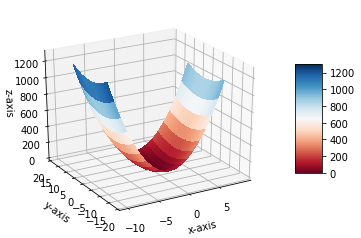

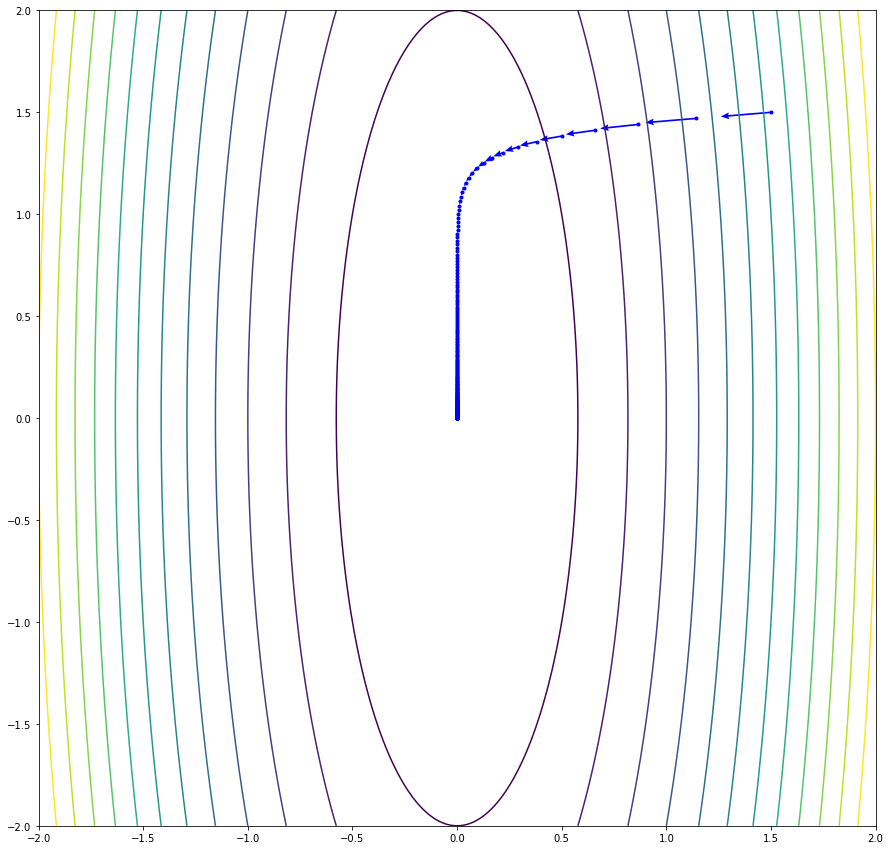

In [74]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
import numpy as np
from pylab import meshgrid

# function to plot
def func(x, y):
    c = sp.Poly(sympys[0]).coeffs()
    print("Function : " + str(c[0])+"x**2 + y**2")
    return int(c[0])*x**2 + y**2

def plot_3D(func):
    x1 = np.arange(-10, 10, 1) # x1 >= 0 according to given conditions
    x2 = np.arange(-10, 10, 1) # x2 <= 1 according to given conditions
    X1,X2 = meshgrid(x1, x2)
    Z = func(X1,X2)

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X1, X2, Z, rstride=1, cstride=1,vmin=0, vmax=np.nanmax(Z), 
                       cmap=plt.cm.RdBu,linewidth=0, antialiased=False)

    ax.set_xlabel('x-axis')
    ax.set_ylabel('y-axis')
    ax.set_zlabel('z-axis')
    ax.view_init(elev=25, azim=-120)
    ax.set_ylim(-20,20)
    fig.colorbar(surf, shrink=0.5, aspect=4)
    plt.show()

    
def plot_gradient(func):
    DG_classic = GD(decay=lambda x: np.linalg.norm(x, ord=1))
    op_pt_2, iters_2, iters_dir_2, n_iter_2, values = DG_classic(np.array([1.5, 1.5]), func)
    nb_pts, x_mi, x_ma, y_mi, y_ma = 200, -2, 2, -2, 2
    fig, ax = plt.subplots(figsize=(15, 15))
    x, y = np.linspace(x_mi, x_ma, nb_pts), np.linspace(x_mi, x_ma, nb_pts)
    X, Y = np.meshgrid(x, y)
    ## Reshaping X, Y for proper evaluation by input function
    x_y = np.vstack([X.reshape(1, -1), Y.reshape(1, -1)]).reshape(1, 2, -1)
    ax.set_xlim(x_mi, x_ma)
    ax.set_ylim(y_mi, y_ma)
    ax.contour(X, Y, func(x_y).reshape(nb_pts, -1), 15)
    ax.quiver(iters_2[:, 0], iters_2[:, 1], iters_dir_2[:, 0], iters_dir_2[:, 1],
          color='b', scale=6, width=0.002, headwidth=4, headlength=5)
    ax.plot(iters_2[:, 0], iters_2[:, 1], 'b.')
    
plot_3D(func)
c = sp.Poly(sympys[0]).coeffs()

plot_gradient(lambda x: int(c[0])*x[0, 0]**2 + x[0, 1]**2)

Le graphique au dessus est significatif du gradient de la fonction généré.
Le but, maintenant est de pouvoir comparer le nombre de condtionnement en fonction du nombre d'iterations. 

Pour cela la fonction $compare()$ va créer un graphique qui va placer des points en fonction l'axe x qui est le nombre de condtionnement et celui de y qui est le nombre d'iteration sur la descente de gradient. 

In [7]:
def compare(step=0.01):
    '''
    plot some condition number depending on number of iteration
    '''
    descent = GD(rate=(lambda x, y, z, grad: step))
    con = []
    iters = []
    for i in range(len(conds)):
        c = sp.Poly(sympys[i]).coeffs()[0]
        res = descent(np.array([5,20]), lambda tab : int(c)*tab[0,0]**2 + tab[0,1]**2)
        con.append(c)
        iters.append(res[3])
        #print("Condition Number:", c, ", Iteration Number:",res[3])
        #print(conds[i][1](np.array([[1,0]])))
        #descent(np.array([5,6]), conds[i][1])

    plt.subplot(311)
    plt.plot(con, iters, 'mo')
    plt.axis([0, 400, 0, 11000])
    plt.subplot(312)
    plt.plot(con, iters, 'mo')
    plt.axis([0, 400, 0, 1000])
    plt.title('Zoom : 0-1000')
    plt.subplot(313)
    plt.plot(con, iters, 'mo')
    plt.axis([0, 400, 0, 100])
    plt.title('Zoom : 0-100')
    plt.tight_layout()
    plt.show()

/home/zined/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: Decay didn't get under tolerance rate.


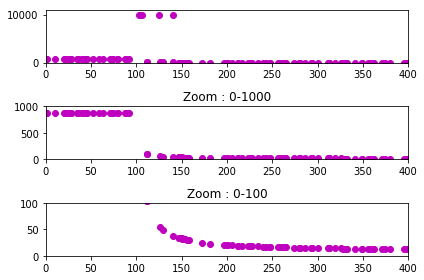

In [8]:
compare()

$compare()$ affiche 3 tailles différentes. La 1ere courbe à un y de 0 a 10000 (max_iter). Le 2eme à un y entre 0 et 1000. Le dernier graphe à un y entre 0 et 100 afin d'observer plus en détails la descente des points.

Nous pouvons d'ores et déjà conjecturer que plus le nombre de conditionnement est grand et plus le nombre d'iteration qui permet de converger vers le minimum de la fonction est faible.

Test with step: 0.01


/home/zined/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: Decay didn't get under tolerance rate.


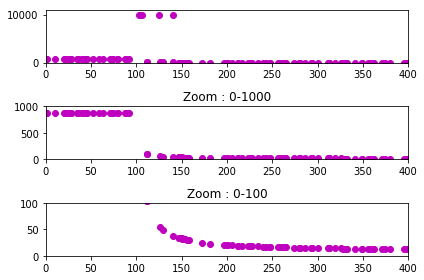

Test with step: 0.1


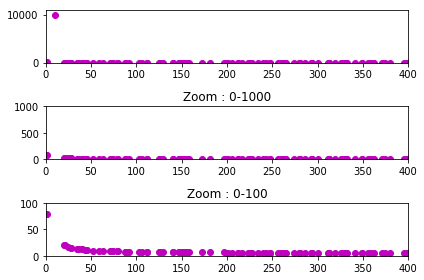

Test with step: 1.0


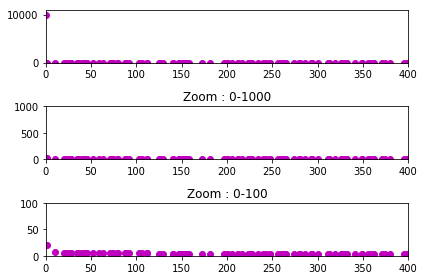

In [9]:
for i in range(1,4):
    print("Test with step:", 10**(i-1)*0.01)
    compare(10**(i-1)*0.01)

In [10]:
def d_sgd(f, x, dx=1e-6):
    x = x.reshape(1, -1)
    dim = x.shape[1]
    sdescent = np.array([0]*dim, dtype=float).reshape(1, -1)
    ## Computing the highest absolute value among coeffs 
    ## of coordinates in gradient.
    abs_grad = np.abs(gradient(f, x, dx))
    imax_diff = np.argmax(abs_grad) 
    sdescent[0, imax_diff] = abs_grad[0, imax_diff]
    return sdescent

Function : 13*x**2+3*x+2+20*y**2+y


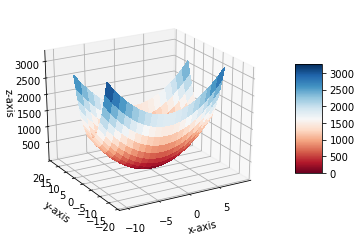

With norm l1: [[-0.11538459 -0.02499998]] num iters: 79
With norm l2: [[-0.11538458 -0.025     ]] num iters: 50


In [92]:
def tab(x, y):
    print("Function : 13*x**2+3*x+2+20*y**2+y")
    return 13*x**2+3*x+2+20*y**2+y

gd_norm1 = GD(d_dir=d_sgd)
gd_norm2 = GD()
functions = [lambda tab : 5*tab[0,0]**2 + 3*tab[0,1]**2 + 200,
             lambda tab : np.exp(tab[0,0]**2 + tab[0,1]**2 + tab[0,1]),
             lambda tab : 13*tab[0,0]**2 + 3*tab[0,0] + 2 + 20*tab[0,1]**2 + tab[0,1],
             lambda tab : 2*np.exp(3*tab[0,0]**2*tab[0,1]**2 + 3*tab[0,0]**2 + 3*tab[0,0]),
             lambda tab : 5*(tab[0,0]**2 + tab[0,1])**2 - (tab[0,1] - 3)**2]

i = np.random.randint(1,len(functions)-1)
ftest = functions[2]
plot_3D(tab)
res = gd_norm1(np.array([0,0]), ftest)
res2 = gd_norm2(np.array([0,0]), ftest)
print("With norm l1:", res[0], "num iters:", res[3])
print("With norm l2:", res2[0], "num iters:", res2[3])

# Méthode d'accélération de la convergence

In [81]:
learning_rate = GD(rate=lambda rate, decay, epochs, f : rate * 1/(1 + decay * epochs))
for i in range(len(functions)):
    res = learning_rate(np.array([0,0]), functions[i], 0.06)
    print("For the function number",i,"f(X)=", functions[i](np.array(res[0])),"for X =", res[0], "and number of iterations =", res[3])

For the function number 0 f(X)= 200 for X = [[0 0]] and number of iterations = 0
For the function number 1 f(X)= 0.7788007830716974 for X = [[ 0.         -0.49999939]] and number of iterations = 3213
For the function number 2 f(X)= 1.8144230769280798 for X = [[-0.11538462 -0.0249995 ]] and number of iterations = 10000
For the function number 3 f(X)= 0.9447331054821075 for X = [[-0.49999983  0.        ]] and number of iterations = 53
For the function number 4 f(X)= -11.24999999999995 for X = [[ 0.         -0.74999989]] and number of iterations = 641


/home/zined/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: Decay didn't get under tolerance rate.


In [14]:

for i in range(len(functions)):
    n = 10000
    step = 0.00005
    rate = step
    while step <= 0.6:
        res = learning_rate(np.array([0,0]), functions[i], step)
        if res[3] < n :
            n = res[3]
            rate = step
        step = step * 2
    print("For the function number ", i, "rate found was :", rate, "and number of iterations = ", n)

For the function number  0 rate found was : 5e-05 and number of iterations =  0


/home/zined/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: Decay didn't get under tolerance rate.


For the function number  1 rate found was : 0.4096 and number of iterations =  14
For the function number  2 rate found was : 0.0256 and number of iterations =  20
For the function number  3 rate found was : 0.1024 and number of iterations =  21
For the function number  4 rate found was : 0.1024 and number of iterations =  15


L'algorithme de Nesterov est une méthode optimale pour la descente de gradient en terme de minimisation d'erreur. On peut considérer cet algorithme comme une descente à deux pas. Ils sont composés d’une première étape qui consiste à descendre classiquement le long d’une direction de descente, et d’une deuxième étape ayant pour but d’accélérer l'algorithme.

In [15]:
def nesterov(f, x,epsilon=1e-8, alpha=0.01, max_iter=10000):
    t1 = 1
    gamma = 0.9
    y_prev = x
    gradie = gradient(f, x)[0]
    
    for i in range(max_iter):
        y_curr = x - alpha * gradie
        x = (1 - gamma) * y_curr + gamma * y_prev
        y_prev = y_curr
        
        gradie = gradient(f, x)[0]
        if np.linalg.norm(gradie) <= epsilon:
            break
            
        tk = (1+np.sqrt(1+4*t1**2))/2
        gamma = (1 - t1) / tk
        t1 = tk
            
    return x, i, f(np.array([x]))

In [16]:
for i in range(len(functions)):
    res = nesterov(functions[i], np.array([0,0]))
    print("for the function number", i, "min(f(X)) =",res[2], "for X =", res[0] , "and number of iterations =", res[1])

for the function number 0 min(f(X)) = 200.0 for X = [0. 0.] and number of iterations = 0
for the function number 1 min(f(X)) = 0.7788007830714049 for X = [ 0.  -0.5] and number of iterations = 731
for the function number 2 min(f(X)) = 1.814423076923077 for X = [-0.11538462 -0.025     ] and number of iterations = 76
for the function number 3 min(f(X)) = 0.9447331054820294 for X = [-0.5  0. ] and number of iterations = 327
for the function number 4 min(f(X)) = -11.249999999999998 for X = [ 0.   -0.75] and number of iterations = 296


In [17]:
for i in range(len(functions)):
    step=0.00005
    n = 10000
    rate = step
    while step <= 1:
        res = nesterov(functions[i],np.array([0,0]),alpha=step)
        if res[1] < n :
            n = res[1]
            rate = step
        step = step * 2
    print("For the function number ", i, "best alpha found was :", rate, "and number of iterations = ", n)

For the function number  0 best alpha found was : 5e-05 and number of iterations =  0
For the function number  1 best alpha found was : 0.4096 and number of iterations =  23
For the function number  2 best alpha found was : 0.8192 and number of iterations =  7


/home/zined/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
/home/zined/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


For the function number  3 best alpha found was : 0.1024 and number of iterations =  21
For the function number  4 best alpha found was : 0.8192 and number of iterations =  12


L'algorithme Adam (pour Adaptive Momentum) est une dérivée des descentes de gradient classiques. L'idée est de prendre en compte à la fois la direction donnée par le gradient, mais aussi par le moment d'ordre 2 (gradient au carré). Ainsi, la fonction prend trois hyperparamètres qui sont alpha : l'équivalent du learning rate, b1 : le coefficient appliqué au gradient, et b2 : le coefficient appliqué au moment d'ordre 2.

In [18]:
def adam(func, x, max_iter=10000, epsilon=1e-8, alpha=0.01, b1=0.9, b2=0.999) :
    m1 = 0.1
    m2 = 0.1
    for t in range(1, max_iter + 1):
        grad_x = gradient(func, x)[0]
        m1 = b1*m1 + (1-b1)*grad_x
        m2 = b2*m2 + (1-b2)*grad_x@grad_x
        m1corr = m1/(1-b1**t)
        m2corr = m2/(1-b2**t)
        prev_x = x
        x = x- (alpha*m1corr)/(np.sqrt(m2corr)+epsilon)
        if np.linalg.norm(x - prev_x) <= epsilon:
            break
    return x,func(np.array([x])), t

In [19]:
for i in range(len(functions)):
    res = adam(functions[i], np.array([0.1,0.1]))
    print("for the function number", i, "min(f(X)) =",res[1], "for X =", res[0] , "and number of iterations =", res[2])

for the function number 0 min(f(X)) = 200.00000000000003 for X = [ 6.17585639e-08 -5.87947286e-08] and number of iterations = 281
for the function number 1 min(f(X)) = 0.7788007830714117 for X = [ 1.45665619e-08 -4.99999908e-01] and number of iterations = 510
for the function number 2 min(f(X)) = 1.8144230769231111 for X = [-0.11538467 -0.025     ] and number of iterations = 289
for the function number 3 min(f(X)) = 0.9447331054821848 for X = [-5.0000000e-01  4.6833409e-07] and number of iterations = 1090
for the function number 4 min(f(X)) = -15495.070331589863 for X = [  11.01944278 -121.47924888] and number of iterations = 10000


Nous allons ici comparer la vitesse de convergence de l'algorithme pour différents hyperparamètres afin de déterminer les meilleurs.

In [20]:
for i in range(len(functions)):
    best_alpha = 0.1
    best_b1 = 0.9
    best_b2 = 0.99
    best_n = 10000
    for alpha in np.arange(0.1,0.6, 0.1):
        for b1 in np.arange(0.8,1,0.05):
            for b2 in np.arange(0.9,1.0,0.03):
                res = adam(functions[i], np.array([0.1,0.1]), alpha=alpha, b1=b1, b2=b2)
                if res[2] < best_n:
                    best_n = res[2]
                    best_alpha = alpha
                    best_b1 = b1
                    best_b2 = b2
    print("for the function number", i, "best hyperparameters = [ alpha=",best_alpha,"b1=",best_b1,"b2=",best_b2, "] and number of iterations =", best_n)

for the function number 0 best hyperparameters = [ alpha= 0.1 b1= 0.8 b2= 0.9900000000000001 ] and number of iterations = 134
for the function number 1 best hyperparameters = [ alpha= 0.1 b1= 0.8 b2= 0.9900000000000001 ] and number of iterations = 141
for the function number 2 best hyperparameters = [ alpha= 0.1 b1= 0.8 b2= 0.9900000000000001 ] and number of iterations = 149
for the function number 3 best hyperparameters = [ alpha= 0.30000000000000004 b1= 0.8 b2= 0.9900000000000001 ] and number of iterations = 144
for the function number 4 best hyperparameters = [ alpha= 0.1 b1= 0.9 b2= 0.99 ] and number of iterations = 10000


Il semble que le triplet (0.1, 0.8,0.99) soit le plus optimisé pour cet algorithme.

# Algortihme de Newton

Tout d'abord, afin de pouvoir tester notre méthode de newton et pour plus tard, nous avons introduit une fonction qui génère des fontions convexes. L'idée est de créer des fonctions convexe.

In [21]:
def generate_convex_function(n = 10):
    res = []
    for i in range(n):
        convex_data_set = [randint(1, 400)*x**(2**randint(1, 5)), sp.exp(randint(1, 400)*x)]
        convex_function = convex_data_set[randint(0, len(convex_data_set) - 1)]
        for i in range(2):
            if randint(0, 1) == 0:
                convex_function += convex_data_set[randint(0, len(convex_data_set) - 1)]
            else:
                convex_function -= convex_data_set[randint(0, len(convex_data_set) - 1)]
        res.append(convex_function)
    return res

In [22]:
print(generate_convex_function(5))

[293*x**4 - 2*exp(155*x), 337*x**2 + 2*exp(184*x), -exp(3*x), 263*x**4, 228*x**8]


La méthode de newton va nous permettre de minimiser une fonction assez rapidement. Pour ce faire il suffit simplement de partir d'un point $X$ $\in$ $\mathbb{R^n}$ d'itérer en modifiant le $X$ par <br> 
$X = X - Hessian(f(X))^-1 J(f(X))$ 

$Hessian(f(X))$ étant la hessienne<br>
$J(f(X))$ étant la jacobienne de la fonction

In [149]:
def stop(matrix, epsilon):
    for i in range(len(matrix)):
        if abs(matrix[i]) > epsilon:
            return False
    return True

def newton_approximation(functions, composante, X, epsilon = 1e-8, max_iter = 1000):
    '''
    minimize the function X
    this function return the vector with the minimum value and iter number
    '''
    functions = sp.Matrix(functions)
    parameters = sp.Matrix(composante)
    dimension = len(functions)
    dim_composante = len(composante)
    subs_dict = {}
    for k in range(max_iter):
        for j in range(dim_composante):
            subs_dict[parameters[j]] = X[j]
        jacobian = functions.jacobian(parameters)
        hessia = sp.hessian(functions, parameters)
        functions_apply = functions.subs(subs_dict)
        jacobian_apply = jacobian.subs(subs_dict)
        hessian_apply = hessia.subs(subs_dict)
        if stop(jacobian_apply, epsilon):
            break
        #Convert sympy matrix to np_array
        XN  = np.array(X).astype(np.float64)
        JFX = np.array(jacobian_apply).astype(np.float64)
        HFX = np.array(hessian_apply).astype(np.float64)
        RES = XN - np.linalg.inv(HFX.T@HFX)@HFX.T @ JFX[0]
        X = RES
        if k + 1 == max_iter:
            print("Max iter ("+ str(k) + ") reached...")
            break
    return X,k

In [150]:
convex_function = generate_convex_function(5)
print("Convex function :", convex_function)

print("Newton method : ")

functions = [[[2*sp.exp(3*x**2*y**2 + 3*x**2 -3*x)]], [[13*x**2+3*x+2+20*y**2+y]], [[5*(x**2 + y)**2 - (y - 3)**2]]]
for function in functions:
    coord, iter = newton_approximation(function, [x, y], [0.1, 0.1])
    print("Function:", function, "| Coord:",coord, "| Nb Iter", iter)

Convex function : [708*x**2 + exp(380*x), 20*x**16, exp(242*x), 144*x**32, -391*x**16]
Newton method : 
Function: [[2*exp(3*x**2*y**2 + 3*x**2 - 3*x)]] | Coord: [ 5.00000000e-01 -1.16569389e-13] | Nb Iter 7
Function: [[13*x**2 + 3*x + 20*y**2 + y + 2]] | Coord: [-0.11538462 -0.025     ] | Nb Iter 1
Function: [[5*(x**2 + y)**2 - (y - 3)**2]] | Coord: [ 6.0320387e-11 -7.5000000e-01] | Nb Iter 9


Le Support Vector Classification est une méthode d'apprentissage supervisé destinées à résoudre des problèmes de Machine Learning comme par exemple la régression. Ainsi, il en va qu'il faille minimiser une fonction de cout. Il est donc important de pouvoir faire des optimisations.